# Importing Required Libraries

In [10]:
import numpy as np
import math
import copy
from scipy.stats import norm
from sklearn.datasets import make_blobs, make_moons, make_circles
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

### Generating blobs

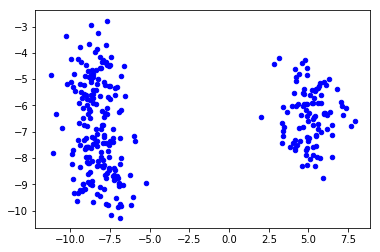

In [11]:
X1, y1 = make_blobs(n_samples=300,centers = 3, n_features=2, cluster_std=1.0)
plt.scatter(X1[:,0],X1[:,1],c='b', s=20)

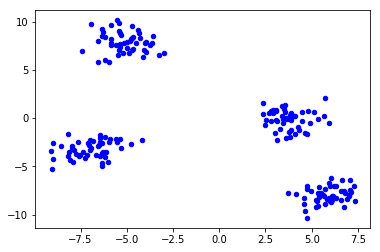

In [12]:
centers = [(-5,8),(-7,-3),(4,0),(6,-8)]
X2, y2 = make_blobs(n_samples=200, centers=centers, n_features=2, cluster_std=1.0)
plt.scatter(X2[:,0],X2[:,1],c='b', s=20)

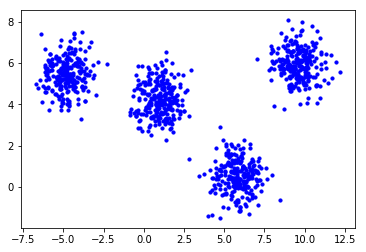

In [13]:
X3,y3 = make_blobs(n_samples=1000,n_features=10,centers=4,cluster_std=0.8,random_state=0)
plt.scatter(X3[:,0],X3[:,1],s=10,c='b')

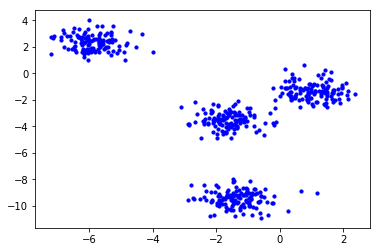

In [14]:
X4,y4 = make_blobs(n_samples=500,n_features=2,centers=4,cluster_std=0.6,random_state = 2)
plt.scatter(X4[:,0],X4[:,1],s=10,c='b')

### Generating moons

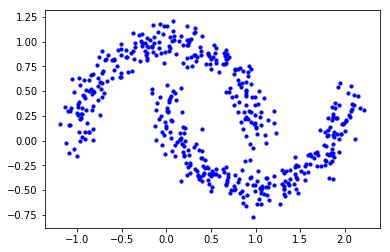

In [15]:
X5,y5 = make_moons(n_samples = 500, noise= 0.1)
plt.scatter(X5[:,0],X5[:,1],s=10,c='b')

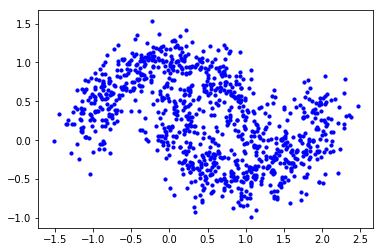

In [16]:
X6,y6 = make_moons(n_samples = 1000, noise= 0.2)
plt.scatter(X6[:,0],X6[:,1],s=10,c='b')

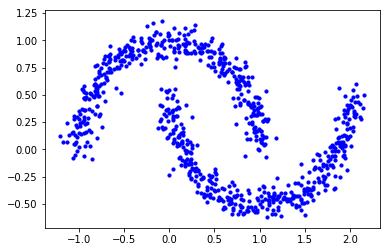

In [17]:
X7,y7 = make_moons(n_samples=800,random_state=2,noise=0.08)
plt.scatter(X7[:,0],X7[:,1],s=10,c='b')

### Generating Circles

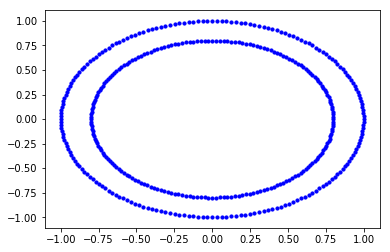

In [18]:
X8, y8 = make_circles(n_samples=400,noise= 0.0) 
plt.scatter(X8[:,0],X8[:,1],s=10,c='b')

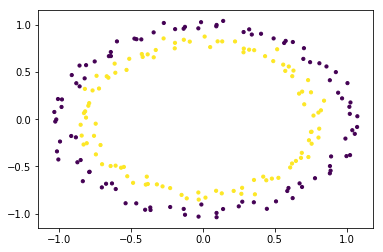

In [19]:
X9, y9 = make_circles(n_samples=200,noise= 0.04, random_state=None) 
plt.scatter(X9[:,0],X9[:,1],s=10,c=y9)

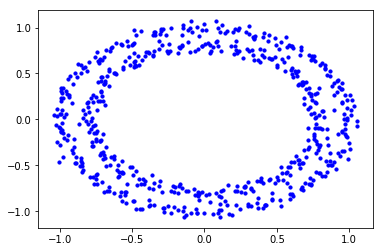

In [20]:
X10, y10 = make_circles(n_samples=600,random_state=2,noise= 0.04) 
plt.scatter(X10[:,0],X10[:,1],s=10,c='b')

# K Means Algorithm

In [21]:
class KMeans:
    def __init__(self, n_centroids, max_iter):
        self.K = n_centroids
        self.max_iter = max_iter
    
    # centroid random initialization 
    def RandomDataPoints(self, X):
        np.random.seed(42)
        
        m = X.shape[0]
        
        # randomly select K data points from data as initial centroids
        centroids = X[np.random.randint(0, m, self.K)]
        
        return centroids
    
    # centroid initialization using k-means++
    def KMeansplusplus(self, X):
        np.random.seed(42)
        
        # choose first centroid randomly from data points 
        centroids = [X[np.random.randint(X.shape[0])]]
        
        # calculate the distance of each data point with it's closest centroid
        # and choose the one with the maximum distance as next centroid
        for i in range(1, self.K):
            squared_distance = np.array([np.min([np.sum(np.square(centroids[c] - X),axis = 1) for c in range(i)],axis = 0)])
            probabilities = squared_distance / squared_distance.sum()
            centroids.append(X[np.argmax(probabilities)])
        return np.array(centroids)
    
    # function that returns an array containing the index to the nearest centroid for each point
    def closest_centroid(self, X, K_centroids):
        distances = np.linalg.norm(X - K_centroids[:, np.newaxis], axis=2)
        return np.argmin(distances, axis = 0)
    
    # function that returns the new centroids assigned from the points closest to them
    def  move_centroids(self, X, K_centroids, indexes):
        return np.array([np.mean(X[indexes == i], axis = 0) for i in range(0,K_centroids.shape[0])])
        
    # clustering method     
    def fit(self, X, init_method):
        
        if init_method == "Random":
            K_centroids = self.RandomDataPoints(X) 
        elif init_method == "K-means++":
            K_centroids = self.KMeansplusplus(X)
            
        
        # Running the clustering algorithm on the data
        prev_centroids = K_centroids.copy()
        for epoch in range(self.max_iter):
            
            indexes = self.closest_centroid(X, K_centroids)
            K_centroids = self.move_centroids(X, K_centroids, indexes)
            if K_centroids.all() == prev_centroids.all():
                break
            prev_centroids = K_centroids.copy()
        clusters = [X[indexes == i] for i in range(0,K_centroids.shape[0])]
        return K_centroids, clusters
    
    # function that plots the data points according to the cluster they have been assigned to 
    def plot_graph(self, centroids, clusters):
        colors = [np.zeros(clusters[i].shape[0],dtype=int) + i for i in range(self.K)]
        datapoints = np.concatenate(clusters)
        colors = np.concatenate(colors)
        plt.scatter(datapoints[:,0], datapoints[:,1], c = colors, s=20)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100, marker = '*')


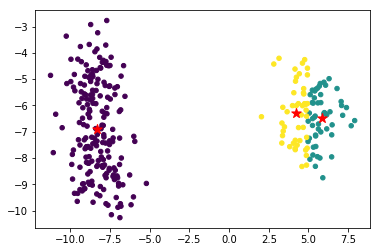

In [22]:
obj = KMeans(3,100)
centroids, clusters = obj.fit(X1, "K-means++")
obj.plot_graph(centroids, clusters)

# Expectation Maximization Algorithm

In [41]:
# function to generate the data to be used in clustering using EM algorithm
def generate_data(k, n_samples):
    data = []
    for i in range(k):
        mean = np.random.rand() + 12*(i+1)
        std_dev = np.random.rand() + np.random.randint(1,4)
        X = np.random.normal(mean, std_dev, n_samples)
        data.append(X)
    return np.concatenate(data)

In [42]:
class Expectation_Maximization:
    def __init__(self, k):
        self.k = k
    
    def parameters_initialization(self, data):
    
        np.random.seed(42)
    
        # initialize the prior probabilties associated with each of the k gaussian components
        probs = np.random.rand(self.k)
        probs = probs / sum(probs)

        # initialize the mean of each of the k gaussian components
        mean = [data[np.random.randint(data.shape[0])]]
        for i in range(1, self.k):
            sqr_dist = np.min([np.square(mean[c] - data) for c in range(i)], axis = 0)
            prob_dist = sqr_dist / sum(sqr_dist)
            mean.append(data[np.argmax(prob_dist)])

        # initialize the standard deviation of each of the k gaussian components
        std_dev = [np.random.rand() + np.random.randint(1,4) for i in range(self.k)]
    
        return [probs, np.array(mean), np.array(std_dev)]
    
    # function to calculate the log likelihood of the data
    def maximum_log_likelihood(self, prob_comp_data):
        maximum_likelihood = np.log(np.sum(prob_comp_data, axis = 1))
        return np.sum(maximum_likelihood)
        
        
    def fit(self, data, iterations):
        
        parameters = self.parameters_initialization(data)
        
        # parameters - a 3-tuple 
        # first element of tuple is probabilities asscociated with each gaussian components
        # second element of tuple is mean of each gaussian component
        # third element of tuple is standard deviation of each gaussian component

        prob_components_given_data = np.zeros((data.shape[0],self.k))
        likelihood_over_iterations = []

        for epoch in range(iterations):

            gaussians = [norm(parameters[1][i], parameters[2][i]) for i in range(self.k)] # k gaussian distributions

            # Expectation step
            for cluster in range(self.k):
                prob_components_given_data[:,cluster] =  gaussians[cluster].pdf(data) * parameters[0][cluster]
            likelihood_over_iterations.append(self.maximum_log_likelihood(prob_components_given_data))
            prob_components_given_data /= np.sum(prob_components_given_data, axis = 1).reshape(prob_components_given_data.shape[0],1)

            # Maximization step
            parameters[0] = np.sum(prob_components_given_data, axis = 0) / prob_components_given_data.shape[0]
            parameters[1] = np.matmul(prob_components_given_data.T, data) / (data.shape[0] * parameters[0])
            parameters[2] =  np.sum(prob_components_given_data * np.square(data[:,np.newaxis] - parameters[1][np.newaxis,:]), axis = 0)
            parameters[2] = (parameters[2] / (data.shape[0] * parameters[0]))**0.5
            
        gaussians = [norm(parameters[1][i], parameters[2][i]) for i in range(self.k)]
        

        return gaussians, likelihood_over_iterations
                                    
    def plot_graph(self, data, gaussians):
        x = np.linspace(data.min()-4, data.max()+4, 200)
        probs = []
        for gaussian in gaussians:
            plt.plot(x, gaussian.pdf(x))
            probs.append(gaussian.pdf(data))
        labels = np.argmax(np.array(probs),axis = 0)
        plt.scatter(data, [0]*len(data),c = labels)


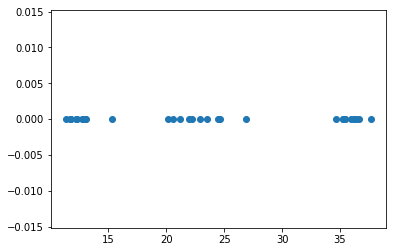

In [43]:
data = generate_data(3,10)
plt.scatter(data, [0]*len(data))

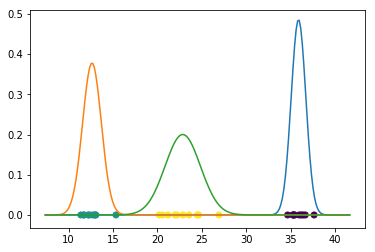

In [44]:
obj = Expectation_Maximization(3)
gaussians, likelihoods = obj.fit(data,10)
obj.plot_graph(data, gaussians)

In [3]:
# function for calculating the average distance of every point of a cluster to every other point within the same cluster
def intracluster_distance(cluster):
    intra_dist = np.zeros((cluster.shape[0],1))
    for i in range(cluster.shape[0]):
        intra_dist[i] = np.sum(np.linalg.norm(cluster - cluster[i],axis = 1), axis = 0)
    return intra_dist / cluster.shape[0]

# Elbow Curve Method

In [46]:
def ElbowCurve(data):
    distortion = []
    for no_clusters in range(1,11):
        obj = KMeans(no_clusters,10)
        centroids, clusters = obj.fit(data, "K-means++")
        Wk = sum(np.concatenate([intracluster_distance(cluster)/2 for cluster in clusters]))
        distortion.append(Wk)
    plt.plot(range(1,len(distortion)+1), distortion, 'bx-')
    plt.xlabel("K  (no. of clusters)")
    plt.ylabel("Distortion")
    plt.title("Elbow Curve")

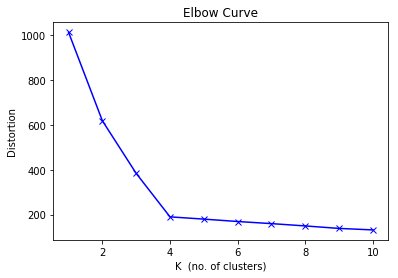

In [47]:
ElbowCurve(X2)

# Silhouette Score Method

In [4]:
# function for calculating the minimum of average distance of every point of a cluster to every other point within the different cluster
def intercluster_distance(curr_cluster, clusters):
            
    min_inter_distance = np.zeros((curr_cluster.shape[0],1))
    for i in range(curr_cluster.shape[0]):
        temp = np.array([np.sum(np.linalg.norm(cluster - curr_cluster[i],axis = 1), axis = 0) for cluster in clusters])
        index = np.argmin(temp)
        min_inter_distance[i] = np.min(temp) / clusters[index].shape[0] 
    return min_inter_distance

In [10]:
def Silhouette_score(data):
    distortion = []
    
    for no_clusters in range(2,11):
        obj = KMeans(no_clusters,10)
        centroids, clusters = obj.fit(data, "K-means++")
        intra_distance = []
        inter_distance = []
        for index in range(len(clusters)): 
            intra_distance.append(intracluster_distance(clusters[index]))
            inter_distance.append(intercluster_distance(clusters[index],(clusters[0:index] + clusters[index+1:])))
        b = np.concatenate(inter_distance)
        a = np.concatenate(intra_distance)
        s = (b - a) /  np.max((b,a), axis = 0)
        s = sum(s) / s.shape[0]
        distortion.append(s)

    plt.plot(range(2,len(distortion)+2), distortion, 'bx-')
    plt.xlabel("K  (no. of clusters)")
    plt.ylabel("Distortion")
    plt.title("Silhouette Score")
    

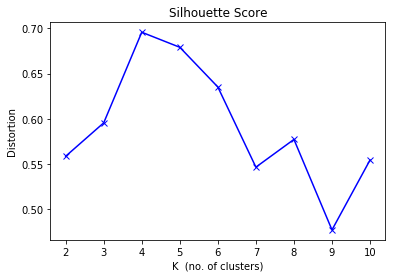

In [16]:
Silhouette_score(x)

# Gap Statistics

In [51]:
def gap_statistics(data, b = 10):
    gaps = []

    for no_clusters in range(2,15):
        obj = KMeans(no_clusters,300)
        centroids, clusters = obj.fit(data, "K-means++")
        ref_datasets_W = []
        for i in range(b):
            ref_dataset = np.random.uniform(0,8,data.shape)
            _, ref_clusters = obj.fit(ref_dataset,"K-means++")
            #Wkb = np.sum(np.array([np.square(np.linalg.norm(ref_clusters[c] - _[c]))for c in range(_.shape[0])]))
            Wkb = sum(np.concatenate([intracluster_distance(cluster)/2 for cluster in ref_clusters]))
            ref_datasets_W.append(Wkb)
            
        ref_datasets_W = np.array(ref_datasets_W)
        Wk = sum(np.concatenate([intracluster_distance(cluster)/2 for cluster in clusters]))
        #Wk = np.sum(np.array([np.square(np.linalg.norm(clusters[c] - centroids[c]))for c in range(centroids.shape[0])]))  
        gap = np.mean(np.log(ref_datasets_W)) - np.log(Wk)
        gaps.append(gap)
    plt.plot(range(2,len(gaps)+2), gaps, 'bx-')
    plt.xlabel("K  (no. of clusters)")
    plt.ylabel("Distortion")
    plt.title("Gap statistic")
    print("Optimal value for k is - ",np.argmax(gaps)+2)
                

Optimal value for k is -  4


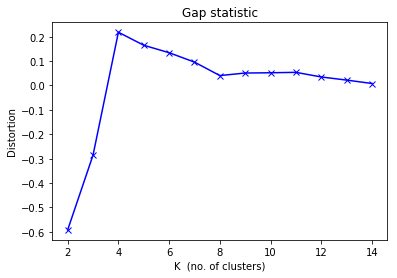

In [52]:
gap = gap_statistics(X2)

# DBScan Method

In [110]:
class DataPointObject:
    def __init__(self, idx, val):
        self.idx = idx # index of the data point in the original dataset
        self.val = val # data point value
        self.neigh_points = []
    
    # function for finding the data points in the eps neighbourhood of a data point
    def setNeighbours(self, data, eps_radius):
        for i in range(len(data)):
            if np.linalg.norm(data[i].val - self.val) <= eps_radius:
                self.neigh_points.append(data[i])
    
        
class DBSCAN:
    def __init__(self, eps, min_pts):
        self.eps = eps
        self.min_pts = min_pts
        self.visited = set()
        self.core_points = []
        self.clusters = None
        

    def density_reachable(self, neigh_pts, curr_label):
        
        for data_pt in neigh_pts:
            # if data point has not been visited yet
            if data_pt.idx not in self.visited:
                self.visited.add(data_pt.idx) 
                # assigning data point to one of the clusters
                self.clusters[data_pt.idx] = curr_label
                
                # if selected data point is a core point
                if len(data_pt.neigh_points) >= self.min_pts:
                    # remove the data point from core_points list
                    self.core_points.remove(data_pt)
                    self.density_reachable(data_pt.neigh_points, curr_label) 
                    
                else:
                    for i in data_pt.neigh_points:
                        if i not in self.core_points:
                            self.clusters[i.idx] = curr_label
                            self.visited.add(i.idx)
    
        
    def fit(self, data):
        
        self.clusters = np.zeros(data.shape[0])
        dataPoints = []
        
        # Convert the points into DataPoint objects
        for idx, dataPt in enumerate(data):
            dataPoints.append(DataPointObject(idx, dataPt))
            
        # finding neigbours of the each data point
        for i in dataPoints:
            i.setNeighbours(dataPoints, self.eps)
        
        # finding the core points in the dataset
        self.core_points  = [pt for pt in dataPoints if len(pt.neigh_points) >= self.min_pts]
        curr_label = 1
        
        while self.core_points:
            # randomly selecting a core data point
            data_pt = self.core_points.pop(np.random.randint(0,len(self.core_points)))
            self.visited.add(data_pt.idx)
            # assigning data point to one of the clusters
            self.clusters[data_pt.idx] = curr_label
            
            # find all the points that are density reachable from selected core point
            self.density_reachable(data_pt.neigh_points, curr_label)
            curr_label += 1
            
        return self.clusters
    
    def plot_graph(self, labels, data):
        plt.scatter(data[:,0], data[:,1], c = labels)

   

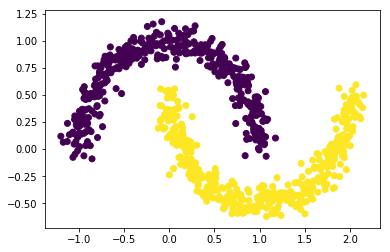

In [104]:
obj = DBSCAN(0.20, 4)
labels = obj.fit(X7)
obj.plot_graph(labels, X7)

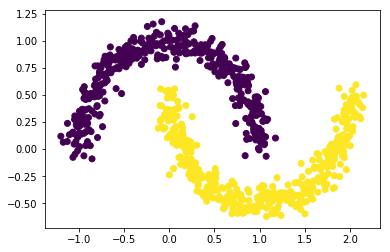

In [29]:
class datapoints:
    def __init__(self,val,idx):
        self.val=val
        self.idx=idx
        self.neighbour_datapoint=[]

    def neighbour_points(self,data,epslion_radius):
        for i in range(len(data)):
            if np.linalg.norm(data[i].val-self.val)<=epslion_radius:
                self.neighbour_datapoint.append(data[i])
    

class DBscan:
    def __init__(self,eps,min_pt):
        self.eps=eps
        self.min_pt=min_pt
        self.visited=set()
        self.core_points=[]
        self.clusters=[]

    def density_reachable(self,neighbours,label):
        for data in neighbours:
            if data.idx not in self.visited:
                self.visited.add(data.idx)
                self.clusters[data.idx]=label
                if len(data.neighbour_datapoint)>=self.min_pt:
                    self.core_points.remove(data)
                    self.density_reachable(data.neighbour_datapoint,label)
                else:
                    for i in data.neighbour_datapoint:
                        if i not in self.core_points:
                            self.clusters[i.idx]=label
                            self.visited.add(i.idx)



    def fit(self,data):
        self.clusters=np.zeros(data.shape[0])
        datapoint_obj=[]
        for idx,data_pts in enumerate(data):  #convert points into objects 
            datapoint_obj.append(datapoints(data_pts,idx))

        for i in datapoint_obj:
            i.neighbour_points(datapoint_obj,self.eps)
            if len(i.neighbour_datapoint)>=self.min_pt:
                self.core_points.append(i)

        label=1
        while self.core_points:
            core_pt=self.core_points.pop(np.random.randint(0,len(self.core_points)))
            self.visited.add(core_pt.idx)
            self.clusters[core_pt.idx]=label
            self.density_reachable(core_pt.neighbour_datapoint,label)
            label+=1
        return self.clusters
    
    def plot_graph(self,labels,data):
        plt.scatter(data[:,0],data[:,1],c=labels)

obj=DBscan(0.2,4)
labels=obj.fit(X7)
obj.plot_graph(labels,X7)